In [85]:
#aid24005 , aid24011
import pandas as pd
import numpy as np
import plotnine
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.decomposition import FastICA
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import kmeans_plusplus
from sklearn.cluster import BisectingKMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.metrics import adjusted_rand_score


In [64]:
#@title Clustering Metrics
#define a performance evaluation function
def performance_score(input_values, cluster_indexes):
    try:
        silh_score = silhouette_score(input_values, cluster_indexes)
        print(' .. Silhouette Coefficient score is {:.2f}'.format(silh_score))
    except:
        print(' .. Warning: could not calculate Silhouette Coefficient score.')
        silh_score = -999

    try:
        ch_score =\
         calinski_harabasz_score(input_values, cluster_indexes)
        print(' .. Calinski-Harabasz Index score is {:.2f}'.format(ch_score))
    except:
        print(' .. Warning: could not calculate Calinski-Harabasz Index score.')
        ch_score = -999

    try:
        db_score = davies_bouldin_score(input_values, cluster_indexes)
        print(' .. Davies-Bouldin Index score is {:.2f}'.format(db_score))
    except:
        print(' .. Warning: could not calculate Davies-Bouldin Index score.')
        db_score = -999

    return silh_score, ch_score, db_score

In [65]:

# @title Load Fashion MIST dataset, create train , test, valid
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
assert X_train_full.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train_full.shape == (60000,)
assert y_test.shape == (10000,)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)


#X_train , X_valid = X_train_full [:-5000] , X_train_full[-5000:]
#y_train , Y_valid = y_train_full [:-5000] , y_train_full[-5000:]

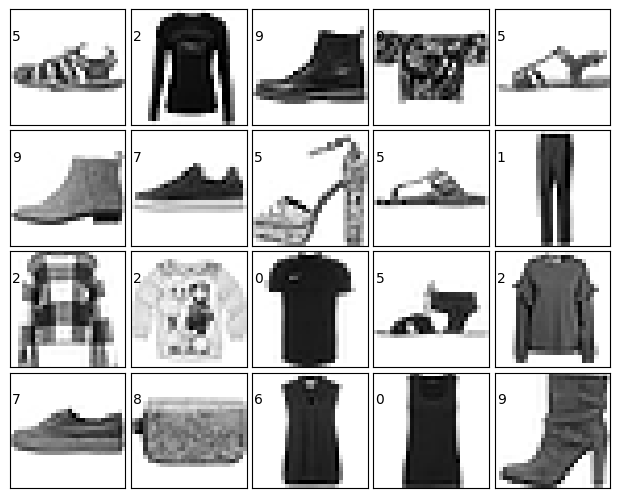

In [66]:
#@title Display Data
#Code from Slides from openeclass

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(20):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(y_train[i]))

In [67]:
# @title  Normalize Data
#better approach
from sklearn.preprocessing import MinMaxScaler

X_train = X_train.reshape(54000, 784)
X_test = X_test.reshape(10000, 784)
X_valid = X_valid.reshape(6000 , 784)

# Change integers to 32-bit floating point numbers
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_valid = X_valid.astype('float32')

#better approach
from sklearn.preprocessing import MinMaxScaler

#from sklearn.preprocessing import StandardScaler
#X_train = StandardScaler().fit_transform(X_train)
#X_valid = StandardScaler().fit_transform(X_valid)
#X_test = StandardScaler().fit_transform(X_test)

# Initialize the MinMaxScaler and fit on the training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)


#Add X_train and X_valid for PCA, FA, FAST_ICA
X_train_valid = np.concatenate((X_train, X_valid), axis=0)



# PCA

In [68]:
# @title PCA
pca = PCA(n_components=0.93 ,random_state=0)

#start time
start_time =time.time()

# Fit and transform the training data
X_train_pca = pca.fit_transform(X_train)

#time end
time_pca = time.time() - start_time

# Transform the test data using the same PCA object
X_test_pca = pca.transform(X_test)

# Check the number of components selected
print("Number of components selected:", pca.n_components_)

Number of components selected: 133


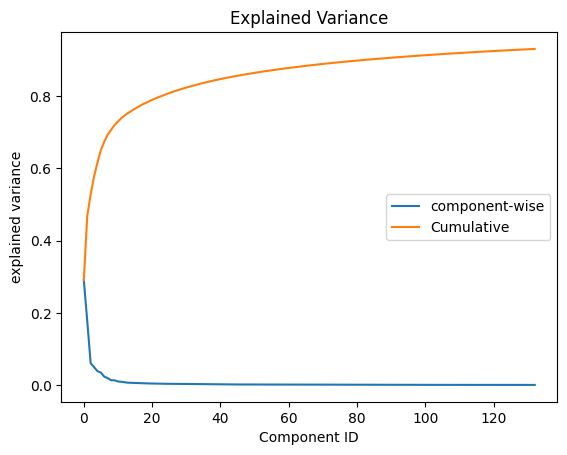

In [69]:
# @title Plot PCA valuation
plt.plot(range(pca.n_components_),\
         pca.explained_variance_ratio_, label='component-wise')
plt.plot(range(pca.n_components_),\
         np.cumsum(pca.explained_variance_ratio_), label='Cumulative')
plt.xlabel("Component ID")
plt.ylabel("explained variance")
plt.legend(loc='best')
plt.title("Explained Variance")
plt.show()

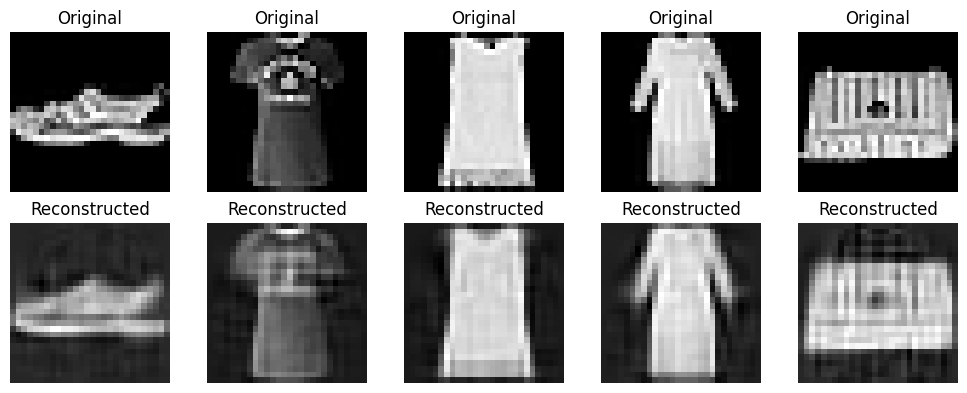

In [70]:
#@title PCA Plot new test images

#create random indices for all the plots of the dimensionality reduction techniques
random_indices = np.random.choice(X_test.shape[0], 8, replace=False)


# Get the original images and apply inverse PCA transformation
original_images = X_test[random_indices]
reconstructed_images = pca.inverse_transform(X_test_pca[random_indices])

# Reshape the images to their original dimensions
original_images = original_images.reshape(-1, 28, 28)
reconstructed_images = reconstructed_images.reshape(-1, 28, 28)

# Create a 2x5 grid for plotting
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(original_images[i], cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


# Factor Analysis

In [7]:
#@title Factor Analysis
fa = FactorAnalysis(n_components=120, random_state=0)

#start time
start_time = time.time()

# Fit and transform the training data
X_train_fa = fa.fit_transform(X_train_valid)

#time end
time_fa = time.time() - start_time

# Transform the test data using the same PCA object
X_test_fa = fa.transform(X_test)



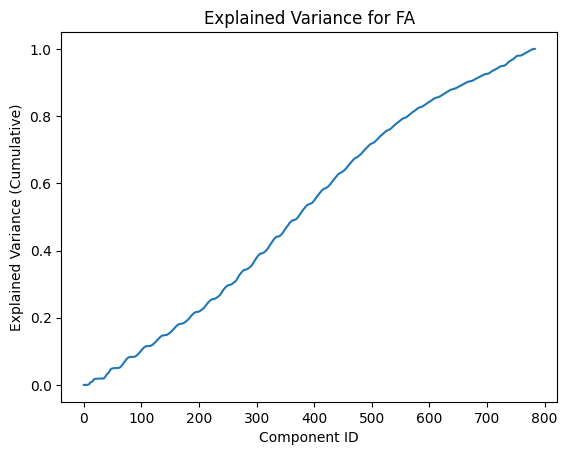

In [34]:
#@title FA Plot umulative explained variance
# Compute cumulative explained variance
explained_variance = np.cumsum(fa.noise_variance_) / np.sum(fa.noise_variance_)

plt.plot(range(784), explained_variance)
plt.xlabel("Component ID")
plt.ylabel("Explained Variance (Cumulative)")
plt.title("Explained Variance for FA")
plt.show()

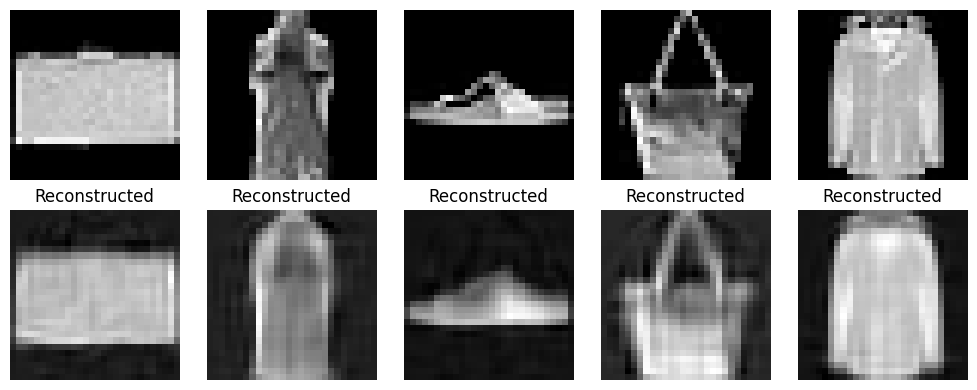

In [37]:
#@title FA plot new test images

#Get the original images and apply inverse PCA transformation
original_images = X_test[random_indices]
# reconstructed_images = fa.inverse_transform(test_img[random_indices])
reconstructed_images = X_test_fa[random_indices].dot(fa.components_) + fa.mean_

original_images = original_images.reshape(-1, 28, 28)
reconstructed_images = reconstructed_images.reshape(-1, 28, 28)

# Create a 2x5 grid for plotting
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(original_images[i], cmap='gray')
    #axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Stacked AutoEncoder (SAE)

In [9]:
# Define the dimensions
original_dim = X_train.shape[1]
encoding_dims = [784, 256, 80]  # You can adjust the number of neurons in each layer
dropout_rate = 0.3  # Adjust the dropout rate as needed

In [10]:
# Build the stacked autoencoder model with dropout layers
input_layer = Input(shape=(original_dim,))
encoded = Dense(encoding_dims[0], activation='relu')(input_layer)
encoded = Dropout(dropout_rate)(encoded)

In [11]:
#@title SAE
###Code from Slides from openeclass

# now the architecture
# Build the encoder part of the stacked autoencoder
for dim in encoding_dims[1:]:
    encoded = Dense(dim, activation='relu')(encoded)
    encoded = Dropout(dropout_rate)(encoded)

# Build the decoder part of the stacked autoencoder
decoded = Dense(encoding_dims[-2], activation='relu')(encoded)
decoded = Dropout(dropout_rate)(decoded)

for dim in reversed(encoding_dims[:-1]):
    decoded = Dense(dim, activation='relu')(decoded)
    decoded = Dropout(dropout_rate)(decoded)

# Output layer
output_layer = Dense(original_dim, activation='sigmoid')(decoded)

In [12]:
SAE = Model(input_layer, output_layer)

# Compile the model
SAE.compile(optimizer='adam', loss='mean_squared_error')

# Define EarlyStopping callback
callback = EarlyStopping(monitor='val_loss', patience=45)

#plot the architecture
SAE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               200960    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 80)                20560     
                                                                 
 dropout_2 (Dropout)         (None, 80)                0     

In [13]:
# Train the autoencoder

#start time
start_time = time.time()

history_SAE = SAE.fit(X_train, X_train,\
                      shuffle=True,\
                    epochs = 10, batch_size = 125,\
                    validation_data=(X_valid , X_valid),\
                    callbacks=[callback])

#end time
time_sae = time.time() - start_time

#predict Test set
# # Define the encoder using the input and the output of the encoder layers
encoder = Model(input_layer, encoded)

# #Apply the mapping to the training & test set of data
X_test_sae = encoder.predict(X_test)

Epoch 1/10
432/432 [==============================] - 29s 64ms/step - loss: 0.0467 - val_loss: 0.0284
Epoch 2/10
432/432 [==============================] - 23s 53ms/step - loss: 0.0313 - val_loss: 0.0274
Epoch 3/10
432/432 [==============================] - 21s 49ms/step - loss: 0.0290 - val_loss: 0.0241
Epoch 4/10
432/432 [==============================] - 23s 53ms/step - loss: 0.0276 - val_loss: 0.0233
Epoch 5/10
432/432 [==============================] - 25s 57ms/step - loss: 0.0267 - val_loss: 0.0227
Epoch 6/10
432/432 [==============================] - 22s 50ms/step - loss: 0.0261 - val_loss: 0.0218
Epoch 7/10
432/432 [==============================] - 22s 51ms/step - loss: 0.0256 - val_loss: 0.0213
Epoch 8/10
432/432 [==============================] - 22s 50ms/step - loss: 0.0252 - val_loss: 0.0217
Epoch 9/10
432/432 [==============================] - 20s 47ms/step - loss: 0.0249 - val_loss: 0.0214
Epoch 10/10
313/313 [==============================] - 1s 4ms/step


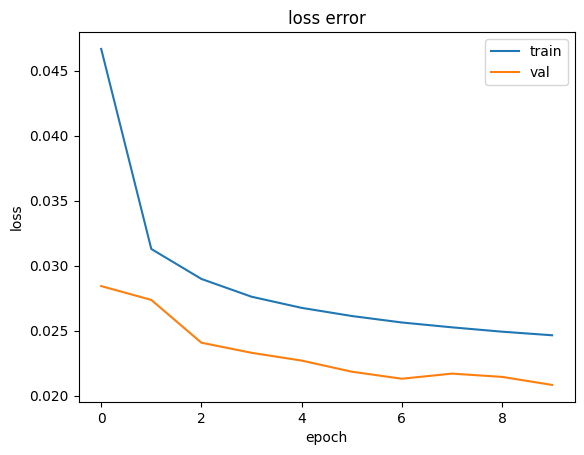

In [14]:
  #@title SAE Plot loss error
plt.plot(history_SAE.history[list(history_SAE.history.keys())[0]])
plt.plot(history_SAE.history[list(history_SAE.history.keys())[1]])
plt.title('loss error')
plt.ylabel(list(history_SAE.history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

1/1 [==============================] - 0s 24ms/step


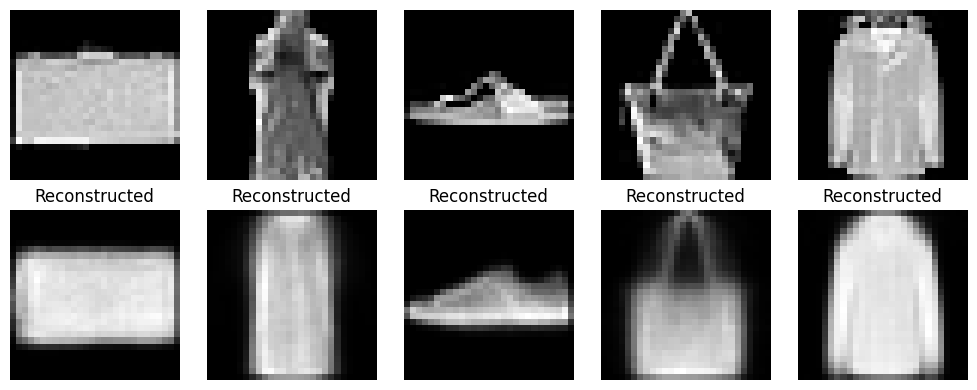

In [38]:
#@title Plot new test images

#predict images
original_images = X_test[random_indices]
reconstructed_images = SAE.predict(original_images)

# Reshape the images to their original dimensions
original_images = original_images.reshape(-1, 28, 28)
reconstructed_images = reconstructed_images.reshape(-1, 28, 28)

# Create a 2x5 grid for plotting
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(original_images[i], cmap='gray')
    #axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()



# CSAE

In [82]:
#@title CSAE
#chat gpt code
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.models import Model

# Assuming your input shape is (28, 28, 1) for grayscale images
input_shape = (28, 28, 1)

# Define the dimensions
original_dim = np.prod(input_shape)
encoding_dims = [64, 32, 16]  # You can adjust the number of filters in each convolutional layer
dropout_rate = 0.3  # Adjust the dropout rate as needed

# Encoder
input_layer = Input(shape=input_shape)
encoded = input_layer

for filters in encoding_dims:
    encoded = Conv2D(filters, (3, 3), activation='relu', padding='same')(encoded)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Dropout(dropout_rate)(encoded)

# Decoder
decoded = encoded
for filters in reversed(encoding_dims[:-1]):
    decoded = Conv2D(filters, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Dropout(dropout_rate)(decoded)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

# Flatten for the fully connected layers
flat = Flatten()(encoded)
flat = Dropout(dropout_rate)(flat)

# Output layer
output_layer = Dense(original_dim, activation='sigmoid')(flat)

# Build the CSAE
CSAE = Model(input_layer, output_layer)

# Compile the model
CSAE.compile(optimizer='adam', loss='mean_squared_error')

# Plot the architecture
CSAE.summary()

#start time
start_time = time.time()

# Train the CSAE
history_CSAE = CSAE.fit(X_train.reshape((-1, 28, 28, 1)), X_train.reshape((-1, original_dim)), \
                        shuffle=True, epochs=5, batch_size=125, \
                        validation_data=(X_valid.reshape((-1, 28, 28, 1)), X_valid.reshape((-1, original_dim))), \
                        callbacks=[callback])

#end time
time_csae = time.time() - start_time

# Predict on the test set
X_test_csae = CSAE.predict(X_test.reshape((-1, 28, 28, 1)))


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                      

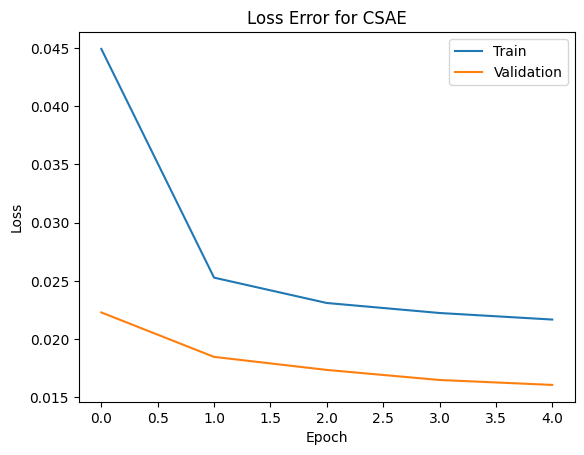

In [51]:
# @title Plot CSAE loss error
# Plot CSAE loss error
plt.plot(history_CSAE.history['loss'])
plt.plot(history_CSAE.history['val_loss'])
plt.title('Loss Error for CSAE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

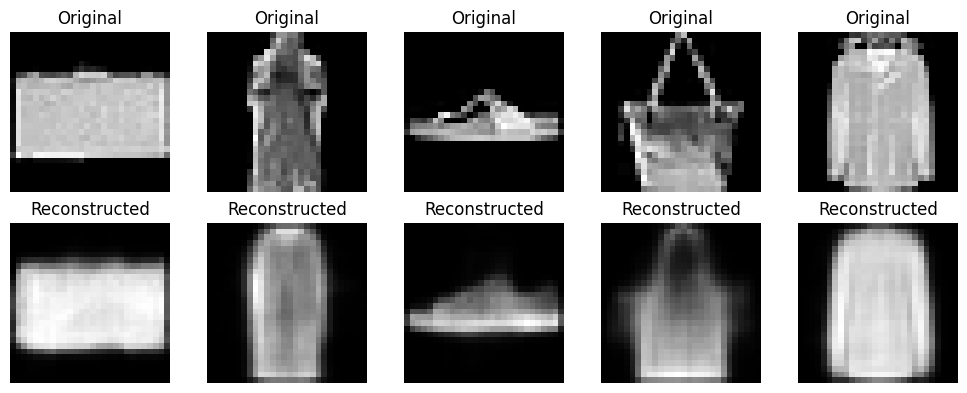

In [39]:
#@title SCAE Plot new test images
# Get the original images and apply inverse PCA transformation
original_images = X_test[random_indices]

# Reconstruct images using CSAE
reconstructed_images = X_test_csae[random_indices]

original_images = original_images.reshape(-1, 28, 28)
reconstructed_images = reconstructed_images.reshape(-1, 28, 28)

# Create a 2x5 grid for plotting
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(original_images[i], cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


#FAST_ICA


In [16]:
#@title Fast_ICA
# Initialize the ICA model with the desired number of components
n_components = 120  # Choose the number of components
ica = FastICA(n_components=n_components, random_state=0)

#start time
start_time = time.time()

# Fit the ICA model to the training data
ica.fit(X_train_valid)

#end time
time_ica = time.time() - start_time

# Transform the test data using the learned components
X_test_ica = ica.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.


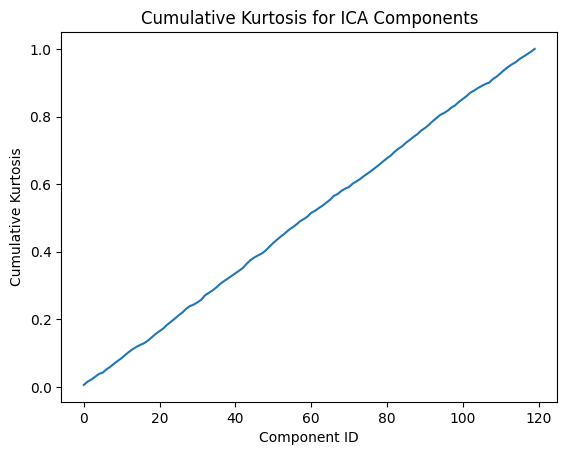

In [54]:
#@title Plot FAST_ICA evaluation
# Get the kurtosis of each component
kurtosis_values = np.abs(ica.components_).mean(axis=1)

# Compute cumulative kurtosis
cumulative_kurtosis = np.cumsum(kurtosis_values) / np.sum(kurtosis_values)

# Plot cumulative kurtosis
plt.plot(range(120), cumulative_kurtosis)
plt.xlabel("Component ID")
plt.ylabel("Cumulative Kurtosis")
plt.title("Cumulative Kurtosis for ICA Components")
plt.show()

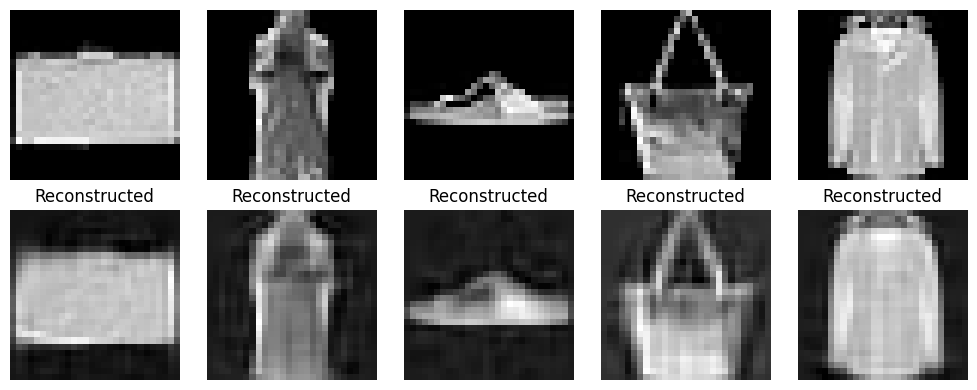

In [40]:
#@title FAST_ICA  PLot new test images
# Get the original images and apply inverse ICA transformation
original_images = X_test[random_indices]
reconstructed_images = X_test_ica[random_indices].dot(ica.mixing_.T) + ica.mean_

# Reshape the images to their original dimensions
original_images = original_images.reshape(-1, 28, 28)
reconstructed_images = reconstructed_images.reshape(-1, 28, 28)

# Create a 2x5 grid for plotting
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(original_images[i], cmap='gray')
    #axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# **MAIN**


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Minibatch kmeans
 .. Silhouette Coefficient score is 0.12
 .. Calinski-Harabasz Index score is 1165.61
 .. Davies-Bouldin Index score is 2.23
DBSCAN
 .. Silhouette Coefficient score is -0.22
 .. Calinski-Harabasz Index score is 138.27
 .. Davies-Bouldin Index score is 1.90


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead


Agglomerative
 .. Silhouette Coefficient score is 0.11
 .. Calinski-Harabasz Index score is 270.69
 .. Davies-Bouldin Index score is 1.13
GMM-EM
 .. Silhouette Coefficient score is 0.12
 .. Calinski-Harabasz Index score is 1034.56
 .. Davies-Bouldin Index score is 2.25
Bisecting kmeans
 .. Silhouette Coefficient score is 0.11
 .. Calinski-Harabasz Index score is 1118.43
 .. Davies-Bouldin Index score is 2.30
Minibatch kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


 .. Silhouette Coefficient score is 0.16
 .. Calinski-Harabasz Index score is 1445.36
 .. Davies-Bouldin Index score is 1.89
DBSCAN
 .. Silhouette Coefficient score is -0.16
 .. Calinski-Harabasz Index score is 98.48
 .. Davies-Bouldin Index score is 2.21


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead


Agglomerative
 .. Silhouette Coefficient score is 0.17
 .. Calinski-Harabasz Index score is 743.86
 .. Davies-Bouldin Index score is 1.28
GMM-EM
 .. Silhouette Coefficient score is 0.10
 .. Calinski-Harabasz Index score is 961.99
 .. Davies-Bouldin Index score is 2.44


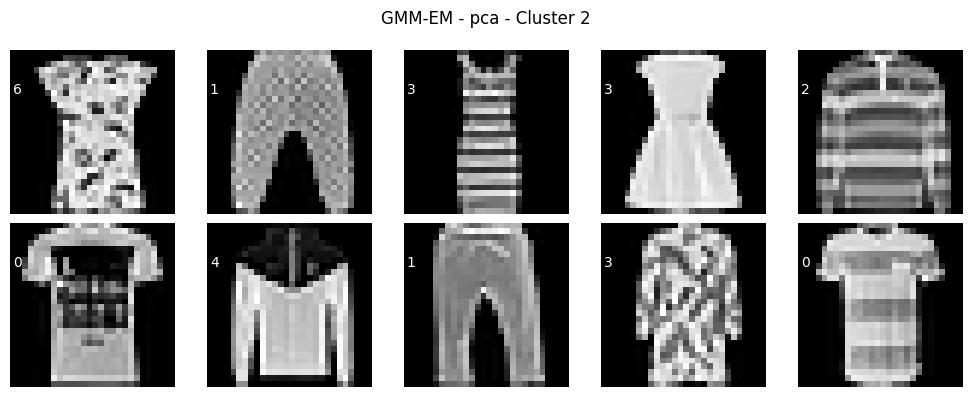

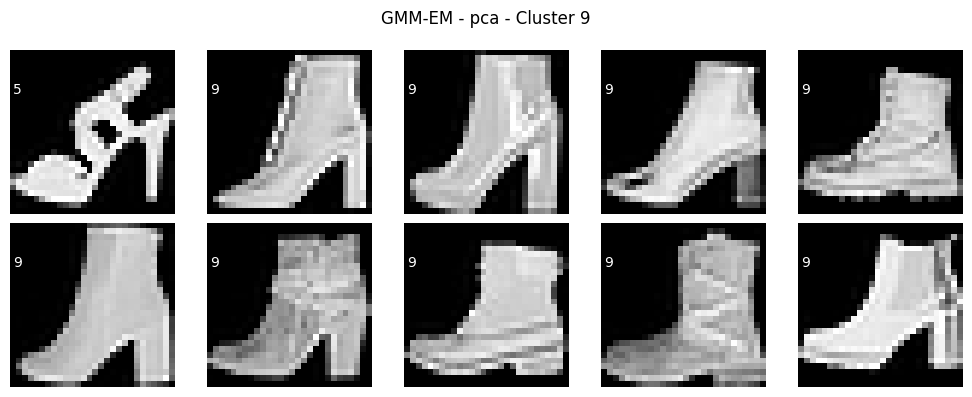

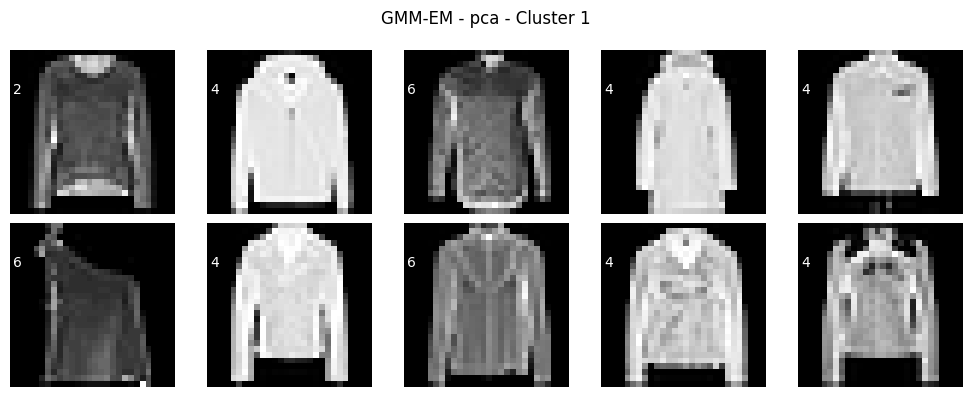

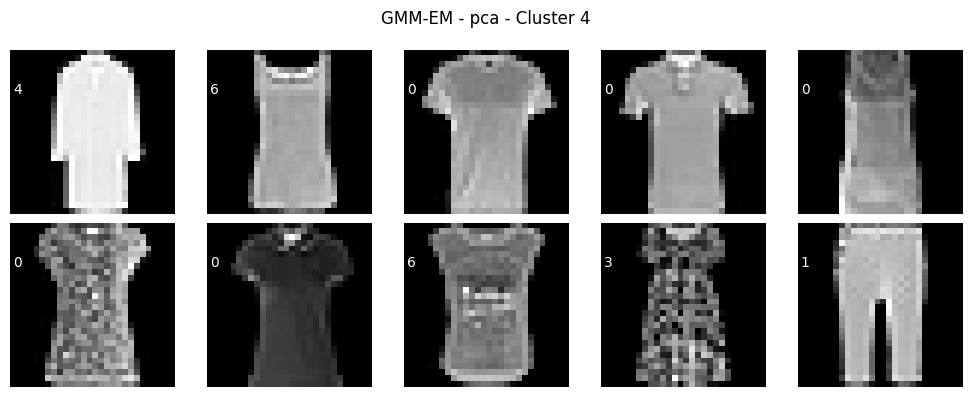

Bisecting kmeans
 .. Silhouette Coefficient score is 0.12
 .. Calinski-Harabasz Index score is 1313.88
 .. Davies-Bouldin Index score is 2.16
Minibatch kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


 .. Silhouette Coefficient score is -0.03
 .. Calinski-Harabasz Index score is 54.45
 .. Davies-Bouldin Index score is 5.46
DBSCAN
 .. Warning: could not calculate Silhouette Coefficient score.
 .. Warning: could not calculate Calinski-Harabasz Index score.
 .. Warning: could not calculate Davies-Bouldin Index score.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead


Agglomerative
 .. Silhouette Coefficient score is 0.53
 .. Calinski-Harabasz Index score is 32.50
 .. Davies-Bouldin Index score is 0.64
GMM-EM
 .. Silhouette Coefficient score is -0.02
 .. Calinski-Harabasz Index score is 68.54
 .. Davies-Bouldin Index score is 6.35
Bisecting kmeans
 .. Silhouette Coefficient score is -0.03
 .. Calinski-Harabasz Index score is 69.78
 .. Davies-Bouldin Index score is 5.86


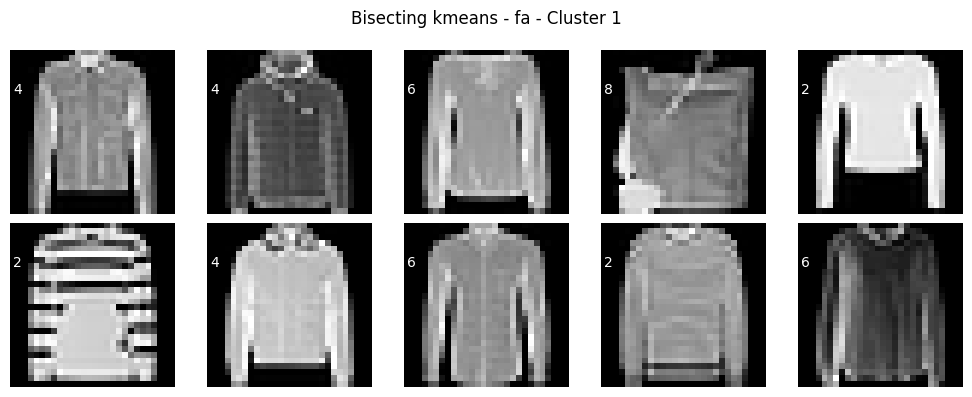

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Minibatch kmeans
 .. Silhouette Coefficient score is 0.23
 .. Calinski-Harabasz Index score is 1144.84
 .. Davies-Bouldin Index score is 1.74
DBSCAN
 .. Silhouette Coefficient score is 0.43
 .. Calinski-Harabasz Index score is 291.62
 .. Davies-Bouldin Index score is 1.65


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead


Agglomerative
 .. Silhouette Coefficient score is 0.30
 .. Calinski-Harabasz Index score is 490.95
 .. Davies-Bouldin Index score is 1.21


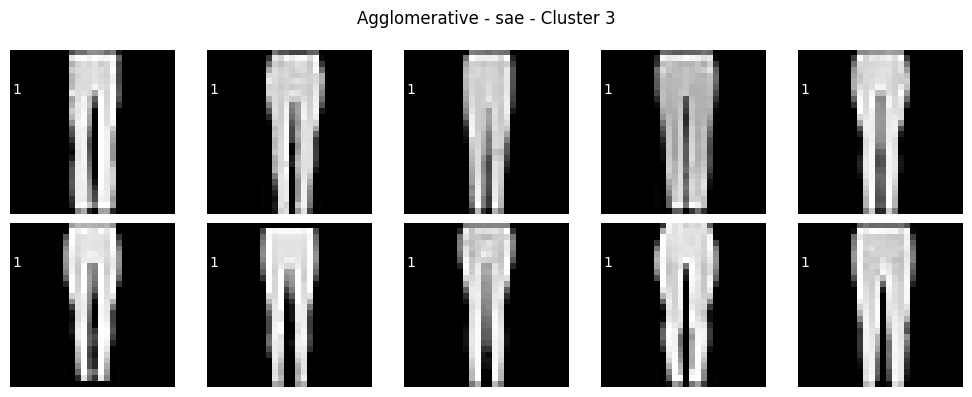

GMM-EM
 .. Silhouette Coefficient score is -0.03
 .. Calinski-Harabasz Index score is 764.59
 .. Davies-Bouldin Index score is 2.00
Bisecting kmeans
 .. Silhouette Coefficient score is 0.22
 .. Calinski-Harabasz Index score is 1157.62
 .. Davies-Bouldin Index score is 1.69


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Minibatch kmeans
 .. Silhouette Coefficient score is 0.23
 .. Calinski-Harabasz Index score is 2434.92
 .. Davies-Bouldin Index score is 1.46


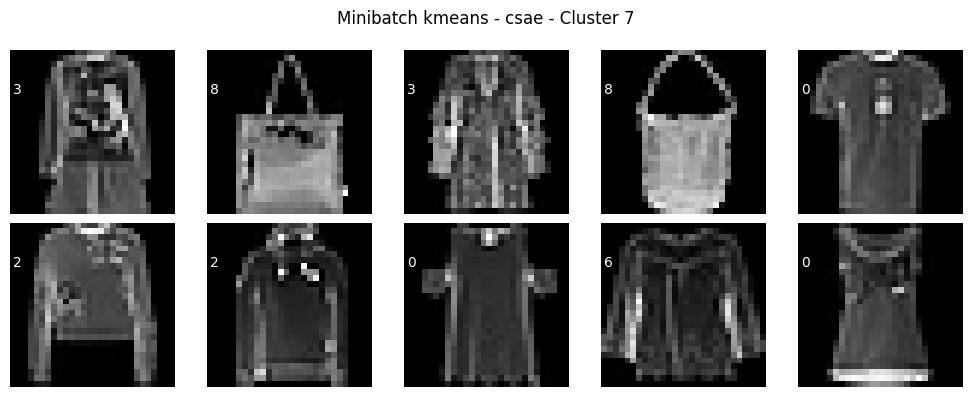

DBSCAN
 .. Silhouette Coefficient score is 0.09
 .. Calinski-Harabasz Index score is 49.34
 .. Davies-Bouldin Index score is 3.54


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead


Agglomerative
 .. Silhouette Coefficient score is 0.21
 .. Calinski-Harabasz Index score is 1297.50
 .. Davies-Bouldin Index score is 1.22
GMM-EM
 .. Silhouette Coefficient score is 0.24
 .. Calinski-Harabasz Index score is 2453.28
 .. Davies-Bouldin Index score is 1.42
Bisecting kmeans
 .. Silhouette Coefficient score is 0.21
 .. Calinski-Harabasz Index score is 2196.70
 .. Davies-Bouldin Index score is 1.65
Minibatch kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


 .. Silhouette Coefficient score is -0.01
 .. Calinski-Harabasz Index score is 46.62
 .. Davies-Bouldin Index score is 5.55
DBSCAN
 .. Warning: could not calculate Silhouette Coefficient score.
 .. Warning: could not calculate Calinski-Harabasz Index score.
 .. Warning: could not calculate Davies-Bouldin Index score.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead


Agglomerative
 .. Silhouette Coefficient score is 0.34
 .. Calinski-Harabasz Index score is 4.50
 .. Davies-Bouldin Index score is 0.47
GMM-EM
 .. Silhouette Coefficient score is -0.02
 .. Calinski-Harabasz Index score is 57.62
 .. Davies-Bouldin Index score is 6.63
Bisecting kmeans
 .. Silhouette Coefficient score is -0.02
 .. Calinski-Harabasz Index score is 44.03
 .. Davies-Bouldin Index score is 7.40


In [84]:
#@title For
def display_random_plots(data, random_indices, clustering_name, drt_name, cluster):
  images = data[random_indices]

  #reshape images
  images = images.reshape(-1, 28, 28)

  fig, axes = plt.subplots(2, 5, figsize=(10, 4))
  plt.suptitle(f"{clustering_name} - {drt_name} - Cluster {cluster}")

  #plot first 5
  for i  in range(5):
    axes[0, i].imshow(images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].text(0, 7, str(y_test[random_indices[i]]), color='white')  # add true label

  for i  in range(5):
    axes[1, i].imshow(images[i+5], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].text(0, 7, str(y_test[random_indices[i + 5]]), color='white')  # add true label


  plt.tight_layout()
  plt.show()


#dimensionality_reduction_techniques
drt =  {'raw':X_test, 'pca' : X_test_pca , 'fa' : X_test_fa , 'sae' : X_test_sae, 'csae' : X_test_csae , 'fast ica' : X_test_ica }

#dimensionality_reduction_techniques times, so could easily import them in final dataframe
drt_times = {'raw' : 0 , 'pca' : time_pca, 'fa' : time_fa , 'sae' : time_sae , 'csae' : time_csae , 'fast ica':time_ica}

#clustering algorithms
clustering_techniques = {'Minibatch kmeans' : MiniBatchKMeans(n_clusters=10, random_state=0) , \
                         'DBSCAN' : DBSCAN(eps=11*0.3, min_samples=11) , \
                         'Agglomerative' : AgglomerativeClustering(n_clusters = 10 , linkage = "average", affinity='euclidean' ),\
                         'GMM-EM' : GaussianMixture(n_components=10 ,covariance_type='full', random_state=0),\
                         'Bisecting kmeans' : BisectingKMeans( n_clusters=10, random_state=0)}

#initialize excel column names
columns= ["Dimendionality Reduction Technique", "Clustering algorithm" , "Training Time for dim. red." , "Time for clusering tech" , "Number of clusters" , "Calinski–Harabasz index", "Davies–Bouldin index", "Silhouette score", "ARI"]
rows = []

for drt_name , data in drt.items():
  for clustering_name , clustering_technique in clustering_techniques.items():
    #start time
    start_time = time.time()
    #Fit and Predict the clusters for the test data
    cluster_labels = clustering_technique.fit_predict(data)
    #end time
    final_time = time.time() -  start_time
    #Compute metrics
    print(clustering_name)
    silh_score, ch_score, db_score = performance_score(data, cluster_labels , )


    rows.append(({
        'Dimendionality Reduction Technique' : drt_name ,
        'Clustering algorithm' : clustering_name ,
        'Training Time for dim. red.' : drt_times[drt_name] ,
        'Time for clusering tech' : final_time ,
        'Number of clusters' : max(cluster_labels) +1 ,
        'Calinski–Harabasz index' : ch_score ,
        'Davies–Bouldin index' : db_score ,
        'Silhouette score' : silh_score ,
        'ARI':  adjusted_rand_score(y_test, cluster_labels)
    }))

    # Random plots based on conditions
    if clustering_name == 'GMM-EM' and drt_name == 'pca':
      random_indices = np.random.choice(np.where(cluster_labels == 2)[0], 10, replace=False) #random select cluster
      display_random_plots(X_test, random_indices, clustering_name, drt_name, 2)

    if clustering_name == 'GMM-EM' and drt_name == 'pca':
      random_indices = np.random.choice(np.where(cluster_labels == 9)[0], 10, replace=False) #random select cluster
      display_random_plots(X_test, random_indices, clustering_name, drt_name, 9)

    if clustering_name == 'GMM-EM' and drt_name == 'pca':
      random_indices = np.random.choice(np.where(cluster_labels == 1)[0], 10, replace=False) #random select cluster
      display_random_plots(X_test, random_indices, clustering_name, drt_name, 1)

    if clustering_name == 'GMM-EM' and drt_name == 'pca':
      random_indices = np.random.choice(np.where(cluster_labels == 4)[0], 10, replace=False) #random select cluster
      display_random_plots(X_test, random_indices, clustering_name, drt_name, 4)

    if clustering_name == 'Minibatch kmeans' and drt_name == 'csae':
      random_indices = np.random.choice(np.where(cluster_labels == 1)[0], 10, replace=False) #random select cluster
      display_random_plots(X_test, random_indices, clustering_name, drt_name, 7)

    if clustering_name == 'Agglomerative' and drt_name == 'sae':
      random_indices = np.random.choice(np.where(cluster_labels == 3)[0], 10, replace=False) #random select cluster
      display_random_plots(X_test, random_indices, clustering_name, drt_name, 3)

    if clustering_name == 'Bisecting kmeans' and drt_name == 'fa':
      random_indices = np.random.choice(np.where(cluster_labels == 3)[0], 10, replace=False) #random select cluster
      display_random_plots(X_test, random_indices, clustering_name, drt_name, 1)



#Clustering Algorithms
Only DBSCAN perform for differet parameters

test  

In [76]:

#@title DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=15)
dbscan.fit(X_test_ica)
cluster_labels = dbscan.labels_
print('we have:', (max(cluster_labels+1)), 'clusters')

silh_score, ch_score, db_score = performance_score(X_test_ica, cluster_labels)

we have: 1 clusters
 .. Warning: could not calculate Silhouette Coefficient score.
 .. Warning: could not calculate Calinski-Harabasz Index score.
 .. Warning: could not calculate Davies-Bouldin Index score.
